# Анализ оттока клиентов в сетевом фитнес-центре.

## 1. Задача.

Задача — провести анализ и подготовить план действий по удержанию клиентов сети фитнес-центров.

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:        
    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.

## 2. Описание проекта.

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- `Churn` — факт оттока в текущем месяце;
- Текущие поля в датасете:
    - Данные клиента за предыдущий до проверки факта оттока месяц:
        - `gender` — пол;
        - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
        - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
        - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
        - `Phone` — наличие контактного телефона;
        - `Age` — возраст;
        - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).        
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
    - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
    - `Group_visits` — факт посещения групповых занятий;
    - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
    - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
    - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## 3. Исследовательский анализ данных.

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

In [2]:
# читаем файл
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.sample(9)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
507,0,0,0,0,1,1,0,32,329.324871,1.0,3,3.436842,3.332887,0
755,0,1,0,0,1,1,0,29,128.664482,1.0,1,3.450940,3.374665,0
1043,1,1,0,0,1,12,1,33,275.025084,11.0,4,0.402946,0.508431,0
1765,1,1,0,1,1,1,0,28,54.870872,1.0,2,1.868083,1.752839,1
1340,1,1,1,0,1,12,1,34,24.923561,5.0,3,3.791391,3.846170,0
1122,0,0,0,0,1,1,0,25,154.010482,1.0,5,2.961949,2.890785,0
309,1,1,1,0,1,6,0,33,76.695751,4.0,7,3.487659,3.445423,0
318,0,1,1,1,1,12,1,34,169.323658,12.0,1,2.077615,2.182571,0
2035,0,1,1,1,1,1,0,31,350.797819,1.0,2,2.172429,2.235588,0


Наименования колонок лучше приведём к общему виду - нижний регистр.

In [4]:
# приводим названия столбцов в нижний регистр
df.columns = df.columns.str.lower()

In [5]:
# общая информация о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


- Пропусков нет
- Всего у нас 4000 строк и 14 колонок.
- Все значения у нас представленны в числовом формате, с этим всё ок.

In [6]:
# посмотрим на уникальные значения "month_to_end_contract"
df['month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

Посмотрим на общие описательные данные нашего DataFrame:

In [7]:
# посмотрим на описательную статистику DataFrame
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


И на данные по факту оттока, где 0 - "Остался", 1 - "Ушёл":

In [8]:
# смотрим на средние значения в двух группах
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Посмотрим на распределения признаков фо факту оттока:

In [9]:
# функция для построения гистограмм для тех, кто ушёл в отток и тех, кто остался
def feat_hist(dataframe, column_to_group, column_to_plot):
    for c in column_to_plot:
        plt.figure(figsize=(12, 5))
        sns.set_style("dark")
        for cl in dataframe[column_to_group].unique():
            sns.distplot(dataframe[dataframe[column_to_group]==cl][c], 
                         label='{} = {}'.format(column_to_group, str(cl)), bins = 50)
        plt.title(c)
        plt.legend(labels=['Ушел', 'Остался'])
        plt.grid(True)
        plt.show()

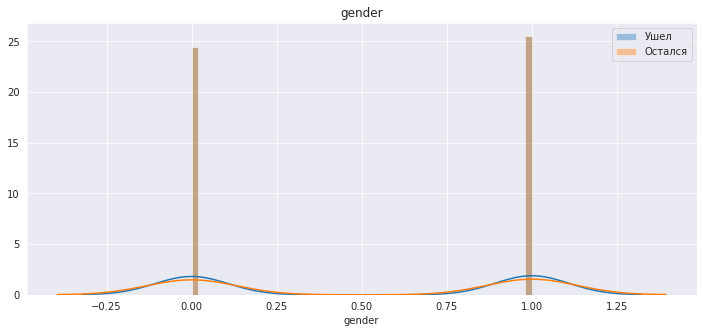

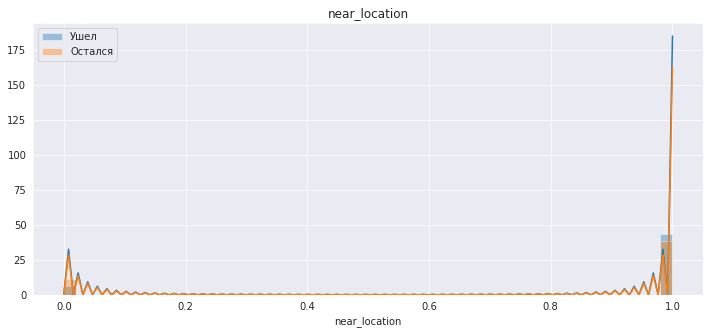

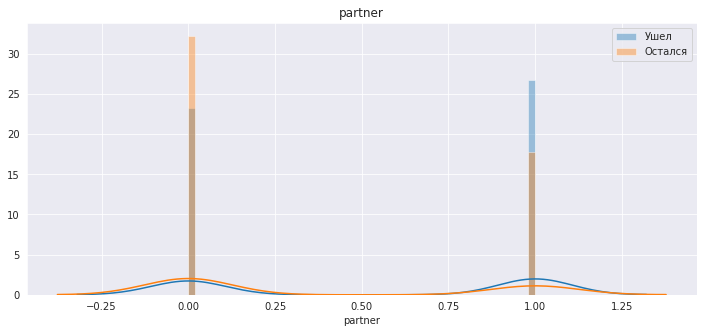

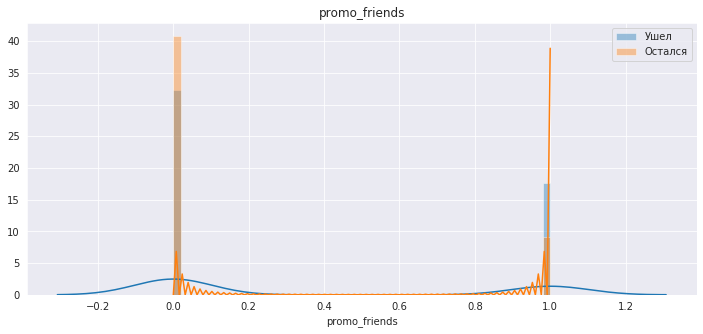

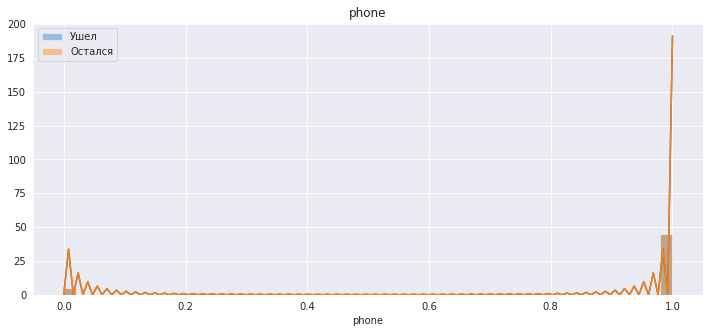

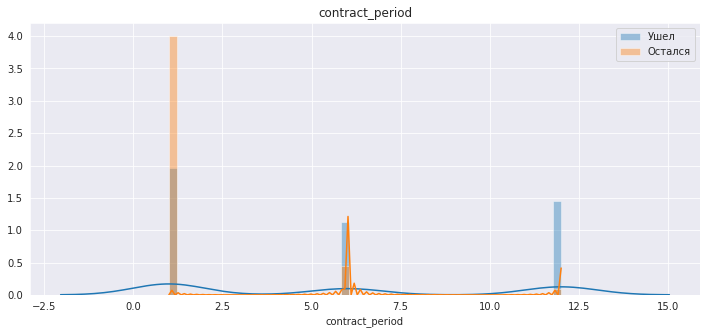

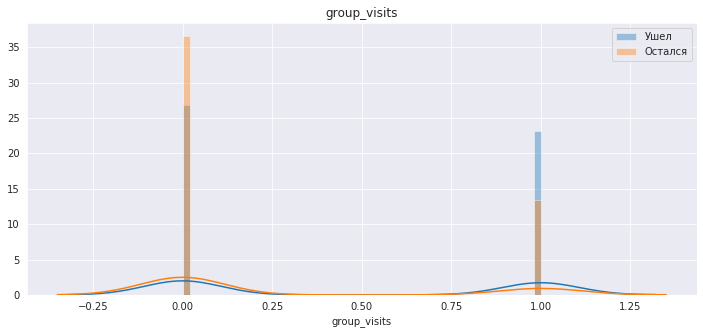

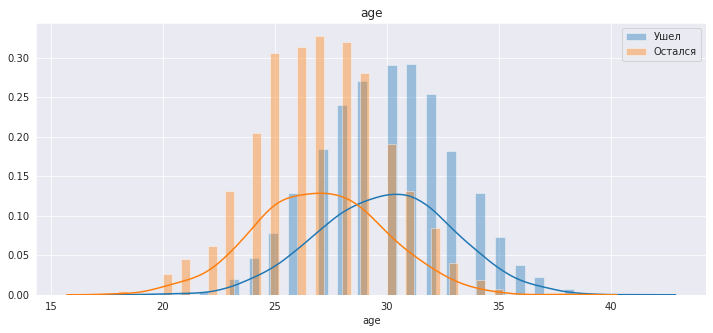

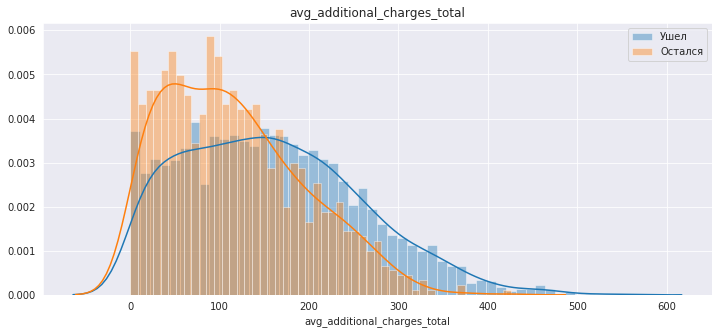

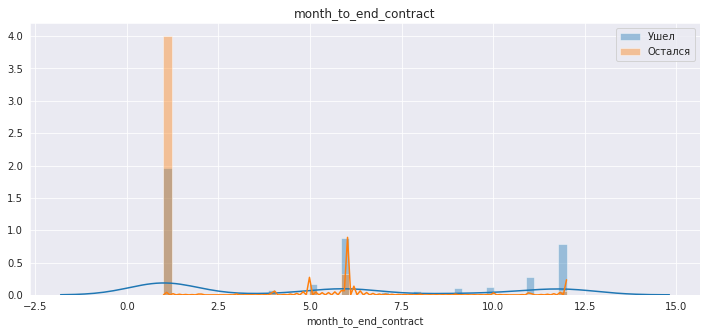

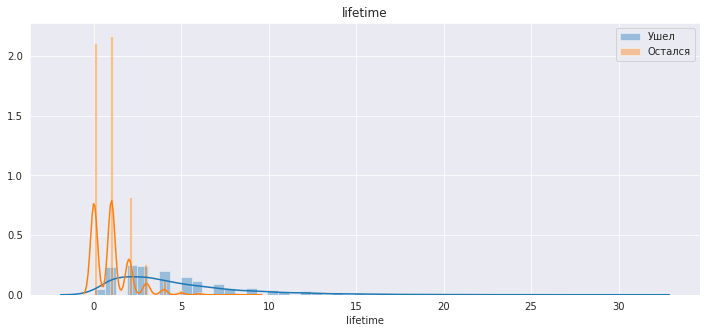

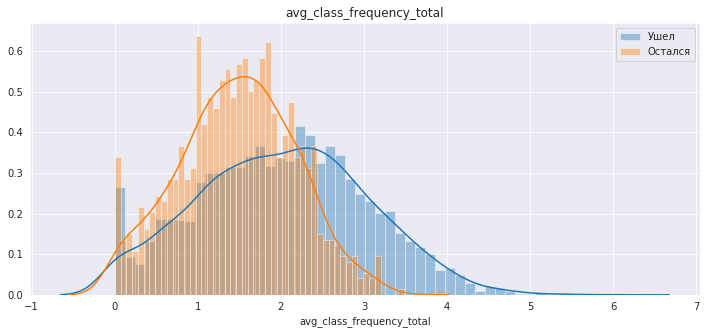

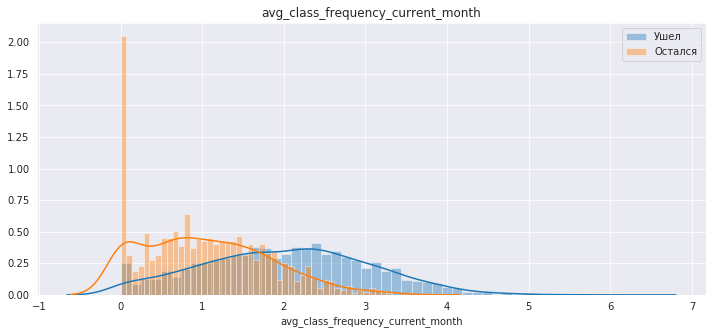

In [10]:
feat_hist(df, 'churn', df.drop('churn', axis = 1).columns)

Из графиков можно сделать следующие заключения:

1. Пол не влияет на отток.
2. Локация расположения фитнес центра в зоне работы/дома, почти не влияет на отток.
3. Те, кто приходят от компаний-партнёров чаще уходят из фитнес-клуба.
4. По акции "Приведи друга" - аналогично.
5. Наличие номера телефона клиента не влияет на отток.
6. Чем больше срок действия абонемента, тем выше вероятность что клиент не использует его. Это видно по двум графикам: по сроку действия абонемента, и по оставшемуся сроку действия абонемента.
7. Те, кто посещают групповые визиты уходят чаще.
8. Люди возрастом до 30 лет чаще остаются.
9. Те, кто тратят больше в фитнес-зале на прочие услуги - уходят чаще.
10. Чаще не бросают занятия фитнесом те, кто посещает его 1-2 раза в неделю в среднем.

Посмотрим, как коррелируют признаки в нашем DataFrame:

In [11]:
# матрица корреляций
cm = df.corr()

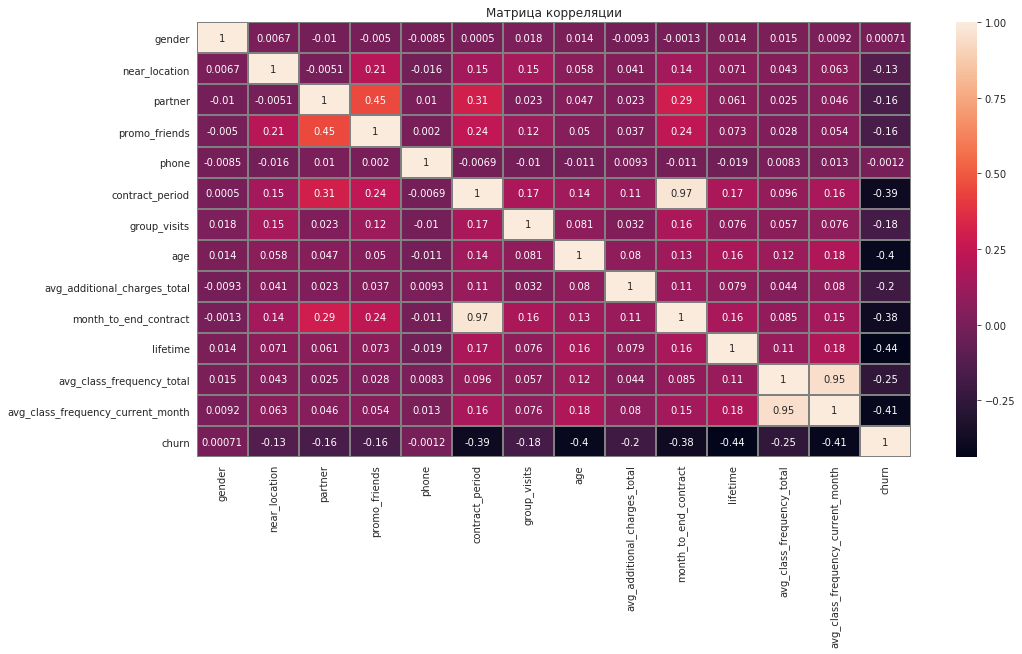

In [12]:
# визуализируем матрицу корреляций
plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=True, linewidths=1, linecolor='gray')
plt.title('Матрица корреляции')
plt.show()

Для дальнейшей работы и построении модели прогназирования оттока клиентов удалим признаки `contract_period` и `avg_class_frequency_current_month` , т.к. они мультиколлинеарны с признаками `month_to_end_contract` и `avg_class_frequency_total` соответственно, и, могут негативно отрозиться на нашей будущей модели.

In [13]:
data = df.drop(['contract_period', 'avg_class_frequency_current_month'], axis=1)

## Вывод.

Данные готовы к построению модели прогнозирования оттока клиентов.

## 4. Модель прогнозирования оттока клиентов.

Т.к. перед нами задача бинарной классификации. Применим 2 алгоритма: Логистическая регрессия, Случайный лес. Оценка качества алгоритмов будет происходить 3 метриками: **accuracy**, **precision_score**, **recall_score**.

In [14]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(['churn'], axis=1)
y = data['churn']

In [15]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# применяем стандартизацию к матрице признаков для обучающей и тестовой выборки
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [17]:
# зададим алгоритмы для нашей модели
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

In [18]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred))
         )

In [19]:
# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy:0.90 precision:0.79 recall:0.81
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
accuracy:0.89 precision:0.79 recall:0.72


## Вывод.

"Логистическая регрессия" показала себя лучше чем "Случайный лес":
**accuracy** - 90%; **precision** - 79%; **recall** - 81% верных прогнозов по оттоку клиентов.

## 5. Кластеризация клиентов.

In [20]:
# стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(data.drop(columns = ['churn']))

In [21]:
# передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage()
linked = linkage(X_sc, method = 'ward')

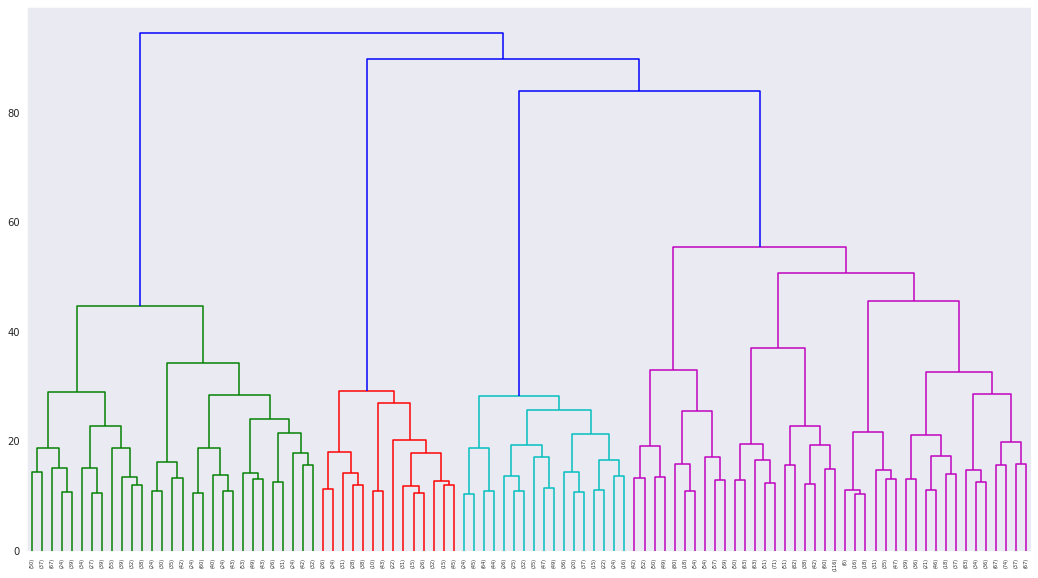

In [22]:
# визуализируем дендрограмму
# чтобы она строилась быстрее, и была более читаемой, 
# оставим основные связи кластеров, а листья скроем в листовые узлы
plt.figure(figsize=(18, 10))  
dendrogram(linked, p=100, truncate_mode='lastp', orientation='top')
plt.show() 

Судя по дендрограмме у нас образовывается 4 кластера. Применим это число кластеров к алгоритму **k-Means** (алгоритм группирует объекты пошагово. При условии, что число кластеров (групп) заранее известно.

In [23]:
# задаём модель k_means с числом кластеров 4
km = KMeans(n_clusters = 4, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(X_sc)

In [24]:
# сохраняем метки кластера в поле датасета
data['cluster_km'] = labels

Посмотрим на средние значения данных по получившимся кластерам.

In [25]:
# выводим статистику по средним значениям признаков по кластеру
data.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,0.266839
1,0.529083,1.000000,0.168345,0.062640,1.0,0.394295,28.963647,142.782276,2.820470,3.307606,1.848885,0.336130
2,0.484585,0.996047,0.940711,0.759684,1.0,0.511462,29.666403,157.830750,7.053755,4.543083,1.977348,0.105138
3,0.499109,0.000000,0.488414,0.076649,1.0,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,0.399287


По средним значения признаков можно заметить, что, чем выше `lifetime`, `promo_friends`, `partner`, `near_location`, `month_to_end_contract`, тем ниже вероятность оттока. Наибольшая вероятность оттока при нулевом параметре `near_location`, а так же 
высокая вероятность оттока при низких показателях `partner` и `promo_friends`.

По доле оттока в каждом кластере:
- Кластер 0 - 27%
- Кластер 1 - 34%
- Кластер 2 - 11%
- Кластер 3 - 40%

Посмотрим на распределения бинарных и количественных признаков для кластеров.

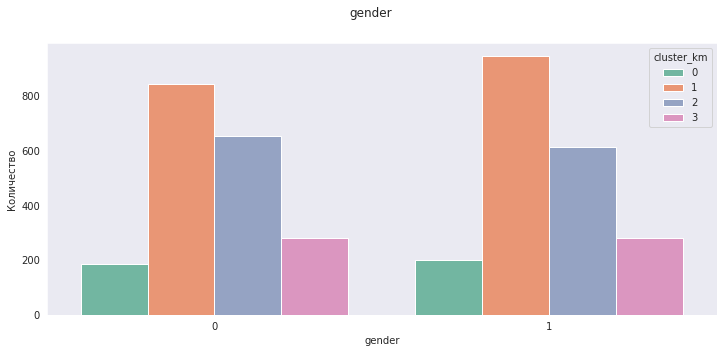

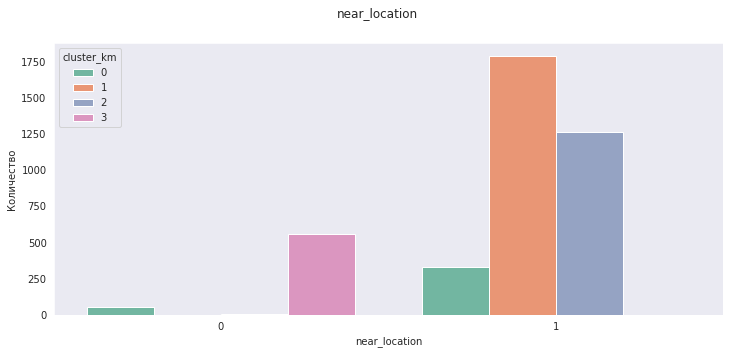

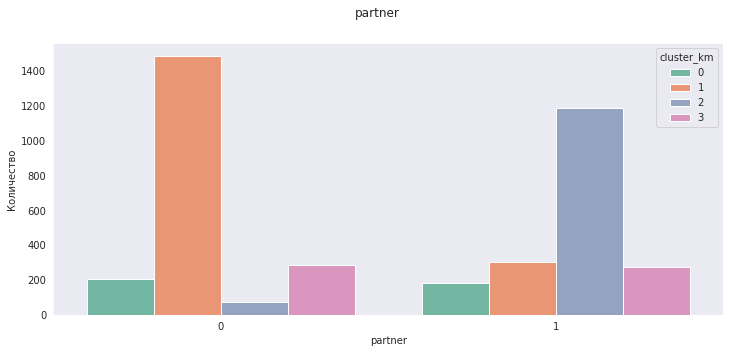

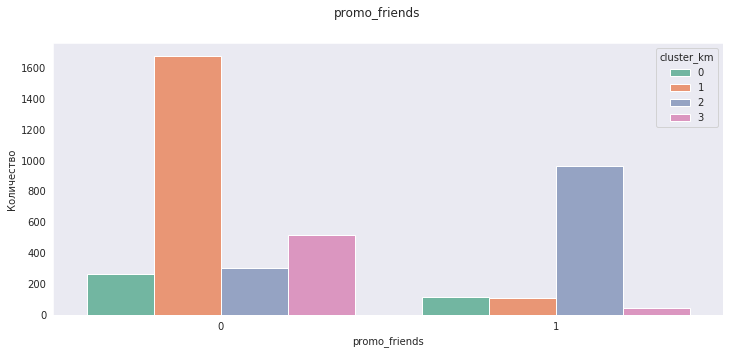

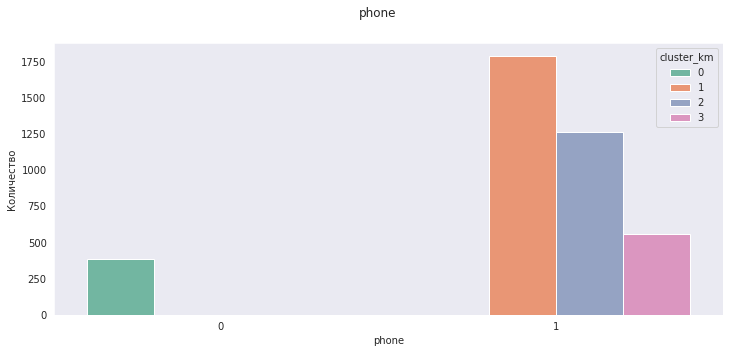

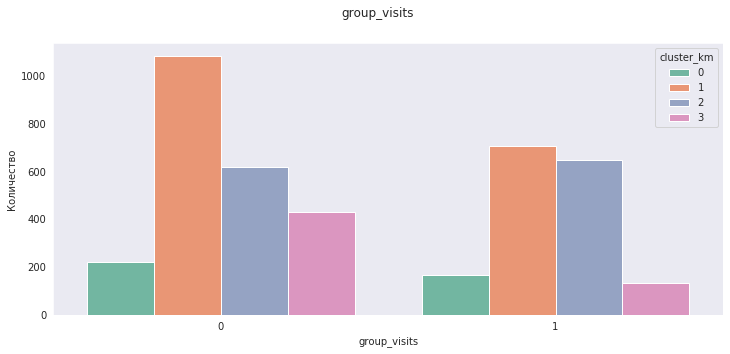

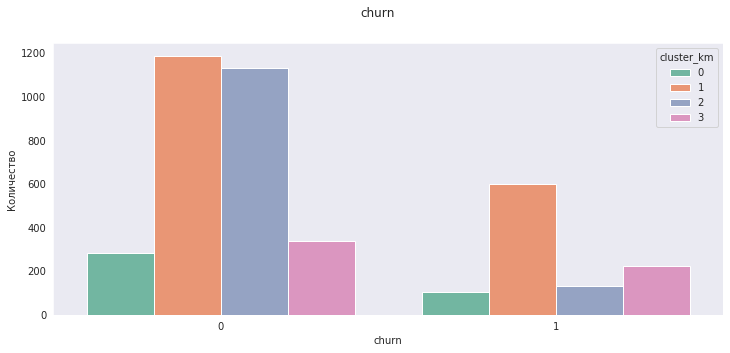

In [26]:
# сохраним список бинарных столбцов
columns_1 = data.drop(['avg_additional_charges_total',
                          'avg_class_frequency_total',
                          'lifetime',
                          'age',
                          'month_to_end_contract',
                          'cluster_km'], axis=1).columns

# строим графики в цикле
for column in columns_1:
    plt.subplots(figsize=(12, 5))
    sns.countplot(data = data, x = column, hue = 'cluster_km', palette = 'Set2')
    plt.suptitle(column)
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.show()

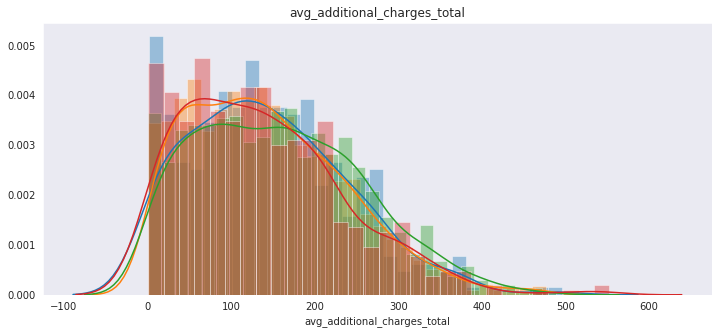

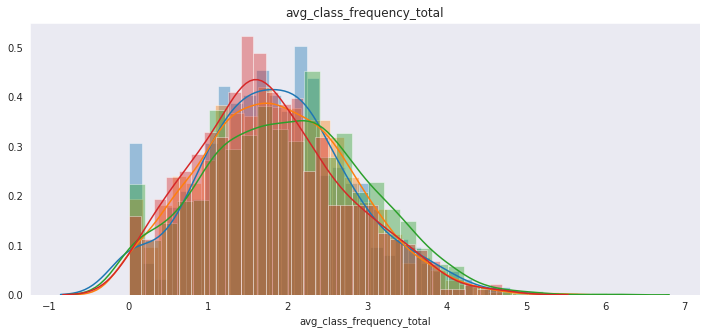

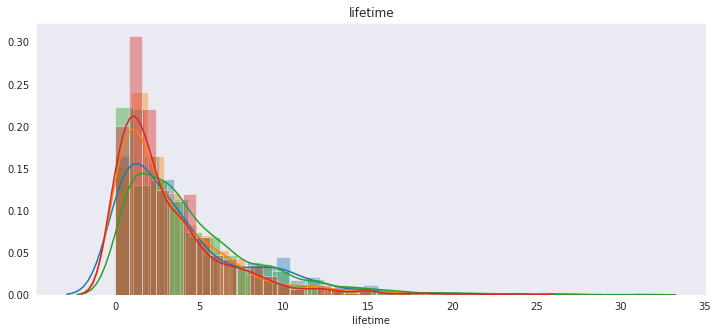

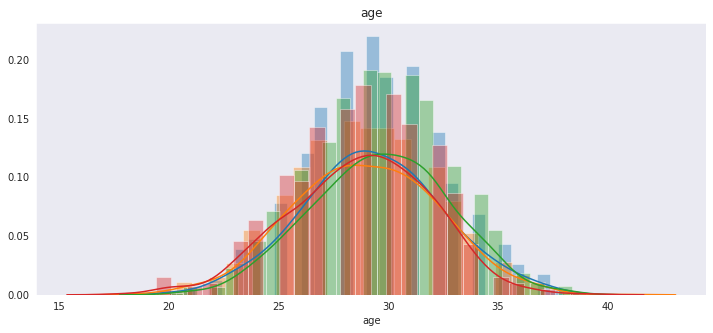

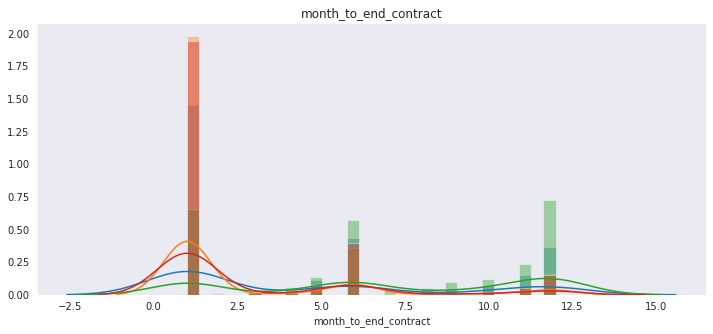

In [27]:
# сохраним список количественных столбцов
columns_2 = ['avg_additional_charges_total',
             'avg_class_frequency_total',
             'lifetime',
             'age',
             'month_to_end_contract']

# строим графики в цикле
for col in columns_2:
    plt.figure(figsize=(12, 5))
    sns.set_style("dark")
    sns.distplot(data.query('cluster_km == 0')[col], bins=30)
    sns.distplot(data.query('cluster_km == 1')[col], bins=30)
    sns.distplot(data.query('cluster_km == 2')[col], bins=30)
    sns.distplot(data.query('cluster_km == 3')[col], bins=30)
    plt.title(col)
    plt.show()

По распределениям признаков для кластеров в целом можно сделать такие же выводы как и по средним значениям.

## Вывод.

Мы классифицировали данные в таблице на 4 выделяющихся кластера методом **k_Means**. По доле оттока:
- Кластер 0 - 27%; 
- Кластер 1 - 34%; 
- Кластер 2 - 11%; 
- Кластер 3 - 40%.

На отток влияют такие признаки, как:  
- отсутсвие фитнес-центра в районе дома/работы `near_location`; 
- привлечение без дополнительных скидок/партнёрских программ `partner` и `promo_friends`.

Удерживающие признаки: 
- фитнес-центр в районе дома/работы `near_location`; 
- большое время жизни клиента с момента первого посещения `lifetime`; 
- привлечение при помощи дополнительных скидок/партнёрских программ`promo_friends` и `partner`; 
- большой остаток занятий по абонементу `month_to_end_contract`.

## Общий Вывод.

1. Мы провели исследовательский анализ данных и построили модель прогнозирования оттока клиентов. Лучше всего себя показала модель "Логистическая регрессия" с оценкамой по трём метрикам: accuracy - 90%; precision - 79%; recall - 81% верных прогнозов по оттоку клиентов.
2. Классифицировали данные в таблице на 4 выделяющихся кластера методом k_Means. По доле оттока:
    - Кластер 0 - 27%;
    - Кластер 1 - 34%;
    - Кластер 2 - 11%;
    - Кластер 3 - 40%.
3. Выяснили какие признаки влияют на отток, а какие наоборот, удерживают клиента:
    - **на отток влияет** - отсутсвие фитнес-центра в районе дома/работы и привлечение без дополнительных скидок/партнёрских программ
    - **удерживают клиента** - фитнес-центр в районе дома/работы, большое время жизни клиента с момента первого посещения, привлечение при помощи дополнительных скидок/партнёрских программ и большой остаток занятий по абонементу.

Из всего вышеперечисленного можно порекомендовать:
- сделать упор в рекламных кампаниях на людей проживающих в районе фитнес-центров (местные группы/чаты в социальных сетях);
- сделать бонусы, либо более привлекательную цену на более длительные контракты;
- разработать более лояльную программу привлечения через партнёров фитнес-центра, либо по акции "приведи друга".
- а так же можно провести дополнительные временные акции с лояльной ценой/бесплатной услугой (кафе, спорт-товары, косметический и массажный салон), например в праздники. Либо делать розыгрыши.
